In [17]:
import little_mallet_wrapper as lmw
import pandas as pd 
import ast 
from lmw import *
import textwrap
import nltk
import matplotlib.pyplot as plt
import numpy as np
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import stopwords
STOP = stopwords.words('english')
STOP.append("amp")

MALLET_PATH = "~/mallet/bin/mallet"
USER_POS_PATH = "../data/user_positive.csv"
USER_SQL_PATH = "../data/user_sqlite.csv"
NAR_POS_PATH = "../../narrative_detection/narrative_posts_by_trained_classification.csv"

## Data Preprocessing

In [2]:
# Positive narrative dataset grouped by user ----
positive_nar = pd.read_csv(NAR_POS_PATH)
positive_users = pd.read_csv(USER_POS_PATH)
positive_users['selftext'] = positive_users['selftext'].apply(ast.literal_eval)
positive_users['merged'] = positive_users['selftext'].apply(lambda x: ' '.join(x))
positive_users['chunks_5'] = [textwrap.wrap(x, len(x)//5) for x in positive_users['merged']]
positive_users['created_utc'] = positive_users['created_utc'].apply(ast.literal_eval)
positive_4 = positive_users[positive_users['created_utc'].apply(lambda x: len(x) == 4)].reset_index(drop=True)
positive_users = positive_users[positive_users['selftext'].apply(lambda x: len(set(x)) < 50 and len(set(x))>2)].reset_index(drop=True)
positive_users = positive_users[positive_users['merged'].apply(lambda x: len(x.split()) > 100 and len(x.split()) < 3000)].reset_index(drop=True)

Summary statistics for positive_4


count     320.000000
mean      213.690625
std       137.644292
min       100.000000
25%       127.000000
50%       171.500000
75%       246.750000
max      1383.000000
dtype: float64

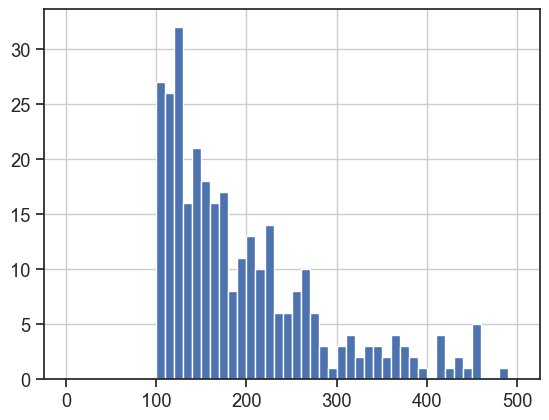

In [3]:
word_count = []
for posts in positive_4['selftext']:
    for post in posts: 
        word_count.append(len(post.split()))
word_count = pd.Series(word_count)
word_count.hist(bins=50, range=[0,500])
print("Summary statistics for positive_4")
word_count.describe()

In [ ]:
# Reading database of all posts ---- 
# removing users with more than 50 posts and fewer than 3 posts
# removing post with less than 100 words
sqlite_user = pd.read_csv(USER_SQL_PATH)
sqlite_user['selftext'] = sqlite_user['selftext'].apply(ast.literal_eval)
sqlite_user['merged'] = sqlite_user['selftext'].apply(lambda x: ' '.join(x))
sqlite_user['created_utc'] = sqlite_user['created_utc'].apply(ast.literal_eval)
sqlite_user['link_flair_text'] = sqlite_user['link_flair_text'].apply(ast.literal_eval)
sqlite_user['title'] = sqlite_user['title'].apply(ast.literal_eval)
sqlite_user['chunks_5'] = [textwrap.wrap(x, len(x)//5) for x in sqlite_user['merged']]
sqlite_user = sqlite_user[sqlite_user['merged'].apply(lambda x: len(x.split()) > 100 and len(x.split()) < 3000)].reset_index(drop=True)
sqlite_user = sqlite_user[sqlite_user['selftext'].apply(lambda x: len(set(x)) < 50 and len(set(x))>2)].reset_index(drop=True)

In [ ]:
word_count = []
for posts in sqlite_user['merged']:
    word_count.append(len(posts.split()))
word_count = pd.Series(word_count)
word_count.hist(bins=50)
print("Summary statistics for sqlite_user")
word_count.describe()

## Topic Modeling (General)
- Training data:
    + All posts in the database where the users post at least three times.
    + Each document represent a chunk derived from a post (each post has 5)

### Data preparation

In [ ]:
# Generating training data ----
training_data = [lmw.process_string(t) for post in sqlite_user['chunks_5'] for t in post]
training_data = [d for d in training_data if d.strip()]

# Generate groupings ----
groupings = []
counting = 0 
for item in sqlite_user['chunks_5']: 
    idx = []
    for post in item: 
        idx.append(counting)
        counting += 1
    groupings.append(idx)

In [ ]:
num_top = [5,10,15,20,30,50]
output_directory_path = "../data/output/general-output/"
for num in num_top: 
    lmw_training(num, output_directory_path, training_data)

### Topic Analysis

In [ ]:
# Examining all topics 
with open(output_directory_path + "top_view.txt", 'w') as f: 
    for num in num_top: 
        topic_keys = lmw.load_topic_keys(output_directory_path + "mallet.topic_keys." + str(num))
        f.write("Topics for k=" + str(num) + "\n")
        for i, t in enumerate(topic_keys):
            line = str(i) + '\t' + ' '.join(t[:10]) + "\n"
            f.write(line)
        f.write('\n')

In [ ]:
num_topics = 15             # Change this to view different output files 

# Viewing topics ---- 
topic_keys = lmw.load_topic_keys(output_directory_path + "mallet.topic_keys." + str(num_topics))
topic_label = []
for i, t in enumerate(topic_keys):
    if t[0] in ["NUM", 'https']: 
        topic_label.append(t[0] + "_" + t[1])
    topic_label.append(t[0])
topic_label

In [ ]:
# For each topic, get the ranking of all the documents
ranking_doc = {}
topic_distributions = lmw.load_topic_distributions(output_directory_path + "mallet.topic_distributions." + str(num_topics))
for i in range(num_topics):
    ranking_doc[topic_label[i]] = []
    for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=i, n=15):
        ranking_doc[topic_label[i]].append(str(training_data.index(d)))

In [ ]:
# Get the position of each document in the ranking
ranking_pos = {}
for topic in ranking_doc: 
    for doc in ranking_doc[topic]: 
        if doc not in ranking_pos:
            ranking_pos[doc] = [(topic, ranking_doc[topic].index(doc))]
        else: 
            ranking_pos[doc].append((topic, ranking_doc[topic].index(doc)))

ranking_pos = {k: sorted(v, key=lambda x: x[1]) for k, v in ranking_pos.items()}
ranking_pos = dict(sorted(ranking_pos.items(), key=lambda item: int(item[0])))

In [ ]:
# For each topic, get its probability of appearing in each document 
ranking_topic_prob = {}
for i in range(num_topics):
    ranking_topic_prob[topic_label[i]] = []
    for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=i, n=len(training_data)):
        ranking_topic_prob[topic_label[i]].append((str(training_data.index(d)), p))
# Sort ranking_topic_prob by the first index of the value tuple
ranking_topic_prob = {k: sorted(v, key=lambda x: int(x[0])) for k, v in ranking_topic_prob.items()}

In [ ]:
# Plot the distribution over time 
# x-axis: created_utc
# y-axis: probability of the topic occurring in the documents (averaged)

Downside: the number of posts by each user are not the same

Should we try to merge the post then chunking then topic modeling? We may lose the temporal information of the posts. 

## Topic Modeling (Narrative Positive)
- Training data:
    + Selected narrative-positive posts from users who post exactly four times. 
    + Each document represents a post. 

### Data preparation

In [36]:
# A dictionary that map index of training data to its position in the positive_4 dataframe
training_data = []
groupings = {}
counting = 0 
for i in range(len(positive_4['selftext'])):
    groupings[i] = []
    for sentence in post: 
        proc = lmw.process_string(sentence, remove_stop_words=True, stop_words=STOP)
        if proc.strip(): 
            training_data.append(proc)
            groupings[i].append(counting)
            counting += 1
print(groupings)

{0: [0, 1, 2, 3], 1: [4, 5, 6, 7], 2: [8, 9, 10, 11], 3: [12, 13, 14, 15], 4: [16, 17, 18, 19], 5: [20, 21, 22, 23], 6: [24, 25, 26, 27], 7: [28, 29, 30, 31], 8: [32, 33, 34, 35], 9: [36, 37, 38, 39], 10: [40, 41, 42, 43], 11: [44, 45, 46, 47], 12: [48, 49, 50, 51], 13: [52, 53, 54, 55], 14: [56, 57, 58, 59], 15: [60, 61, 62, 63], 16: [64, 65, 66, 67], 17: [68, 69, 70, 71], 18: [72, 73, 74, 75], 19: [76, 77, 78, 79], 20: [80, 81, 82, 83], 21: [84, 85, 86, 87], 22: [88, 89, 90, 91], 23: [92, 93, 94, 95], 24: [96, 97, 98, 99], 25: [100, 101, 102, 103], 26: [104, 105, 106, 107], 27: [108, 109, 110, 111], 28: [112, 113, 114, 115], 29: [116, 117, 118, 119], 30: [120, 121, 122, 123], 31: [124, 125, 126, 127], 32: [128, 129, 130, 131], 33: [132, 133, 134, 135], 34: [136, 137, 138, 139], 35: [140, 141, 142, 143], 36: [144, 145, 146, 147], 37: [148, 149, 150, 151], 38: [152, 153, 154, 155], 39: [156, 157, 158, 159], 40: [160, 161, 162, 163], 41: [164, 165, 166, 167], 42: [168, 169, 170, 171], 4

In [5]:
num_top = [5,10,15,20]
output_directory_path = "../data/output/pos-output/utc-chunked/"
for num in num_top: 
    lmw_training(num, output_directory_path, training_data)

Importing data...
Complete
Training topic model...


Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 617
total tokens: 31259
<10> LL/token: -8.39181
<20> LL/token: -8.23438
<30> LL/token: -8.14732
<40> LL/token: -8.10647

0	1	NUM weight know even want really calories way time gain never back body something stop since lot would scared wanted 
1	1	get really bad right time fucking told things thing well take could else work never many past like bit shit 
2	1	eat like feel eating food want day going still days weight today started recover keep healthy think body made week 
3	1	know like people much also years months hate feel make think said disorder year still better family see lose always 
4	1	recovery NUM want anyone life every one look would foods even without help went anymore end mom fat anorexia getting 

<50> LL/token: -8.09877
<60> LL/token: -8.06751
<70> LL/token: -8.04243
<80> LL/token: -8.04005
<90> LL/token: -8.03672

0	1	NUM weight even really never much know body way calories want lot fat time gain

Complete
Importing data...
Complete
Training topic model...


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 617
total tokens: 31259
<10> LL/token: -8.57091
<20> LL/token: -8.36421
<30> LL/token: -8.28658
<40> LL/token: -8.24088

0	0.5	like feel really eat want know food going never always days purging though would something purge feeling anymore literally day 
1	0.5	one food ate mom never people wanted told know say bad shit good lot normal yesterday away right anyone hate 
2	0.5	really would eating weight think healthy need foods eat like food still help full feel make bmi feels lose thought 
3	0.5	like feel body look even fat family back parents weight hate ever underweight need much recover get skinny got amount 
4	0.5	said time made way people got fucking work see first last big two thing disorder tried school looked everything worse 
5	0.5	weight years life NUM every lost since recovery however stomach treatment hours health brain working body wish possible believe relapse 
6	0.5	want much know going get weigh

Complete
Importing data...
Complete
Training topic model...


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 617
total tokens: 31259
<10> LL/token: -8.61991
<20> LL/token: -8.43695
<30> LL/token: -8.3611
<40> LL/token: -8.31444

0	0.33333	like even good see right going life think every trying got also literally let part felt without believe honestly loss 
1	0.33333	get really anyone time idk need last enough everything disorder hate also things feeling making think talk scared guess maybe 
2	0.33333	NUM even mom family one feel eating also skinny could take sure people always sister taking sorry already nothing anxiety 
3	0.33333	want know get stop people never still back well months could point would better even keep anymore need really wish 
4	0.33333	feel like really bit know getting something weeks told literally time two fucking morning try kind weight actually anymore since 
5	0.33333	food eating eat normal day able people going keep days different wanted breakfast time less restriction fear without tried maki

Complete
Importing data...
Complete
Training topic model...


Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 617
total tokens: 31259
<10> LL/token: -8.70607
<20> LL/token: -8.51085
<30> LL/token: -8.44065
<40> LL/token: -8.386

0	0.25	food going even taking like time trying least already issues physical money anyway triggering spent high sleep hope workout super 
1	0.25	NUM much never eat eating going months way get recover hungry also full keep would time less hunger whole three 
2	0.25	weight much fat mom body would family days lose back fear bit idk really stuck getting muscle health anyone got 
3	0.25	know really said someone made maybe literally actually normal guess fuck school self way idea post though asked diet part 
4	0.25	really purging even gain stop think know binging need binge since sure something right next purge year anxiety exercise happy 
5	0.25	feel like want good things enough skinny first one get wanted ever almost life see every old world told honestly 
6	0.25	much home got make back thing wo

Complete


### Topic analysis

In [6]:
# Examining all topics 
with open(output_directory_path + "top_view.txt", 'w') as f: 
    for num in num_top: 
        topic_keys = lmw.load_topic_keys(output_directory_path + "mallet.topic_keys." + str(num))
        f.write("Topics for k=" + str(num) + "\n")
        for i, t in enumerate(topic_keys):
            line = str(i) + '\t' + ' '.join(t[:10]) + "\n"
            f.write(line)
        f.write('\n')

In [13]:
num_topics = 15             # Change this to view different output files 

# Viewing topics ---- 
topic_keys = lmw.load_topic_keys(output_directory_path + "mallet.topic_keys." + str(num_topics))
topic_label = []
for i, t in enumerate(topic_keys):
    topic_label.append(' '.join(t[0:5]))
topic_label

['life mental every physical recovery',
 'like feel know want really',
 'heart cake medical high rate',
 'comments people one dont literally',
 'back got hate fucking want',
 'extremely money food meals brain',
 'said diet another self asking',
 'look thin see photos hair',
 'weight NUM fat still gain',
 'eat NUM food day eating',
 'take die constipation symptoms doctors',
 'body NUM recovery months eating',
 'weight bmi recovery want treatment',
 'get parents help advice think',
 'NUM purging years purge stop']

In [30]:
# For each topic, get the ranking of all the documents
ranking_doc = {}
topic_distributions = lmw.load_topic_distributions(output_directory_path + "/mallet.topic_distributions." + str(num_topics))
for i in range(num_topics):
    ranking_doc[topic_label[i]] = []
    for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=i, n=len(training_data)):
        ranking_doc[topic_label[i]].append(str(training_data.index(d)))
print(ranking_doc)

{'life mental every physical recovery': ['158', '158', '157', '232', '157', '209', '233', '234', '211', '102', '298', '297', '130', '131', '278', '70', '111', '277', '124', '318', '100', '84', '35', '212', '86', '79', '228', '72', '247', '314', '39', '153', '206', '284', '43', '198', '185', '276', '309', '3', '62', '118', '244', '194', '207', '216', '7', '173', '88', '275', '68', '36', '174', '114', '67', '10', '252', '139', '246', '215', '296', '316', '170', '175', '38', '55', '31', '187', '98', '263', '61', '248', '116', '179', '267', '51', '319', '108', '78', '119', '115', '166', '208', '54', '113', '2', '305', '103', '304', '56', '203', '256', '287', '15', '91', '49', '126', '315', '120', '1', '134', '107', '34', '82', '224', '254', '255', '77', '172', '307', '75', '217', '112', '65', '201', '59', '312', '242', '306', '273', '299', '271', '18', '58', '257', '294', '200', '29', '136', '20', '156', '156', '190', '202', '184', '12', '230', '14', '96', '64', '97', '281', '159', '159', 

In [15]:
# For each topic, get its probability of appearing in each document 
ranking_topic_prob = {}
for i in range(num_topics):
    ranking_topic_prob[topic_label[i]] = []
    for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=i, n=len(training_data)):
        ranking_topic_prob[topic_label[i]].append((str(training_data.index(d)), p))
# Sort ranking_topic_prob by the first index of the value tuple
ranking_topic_prob = {k: sorted(v, key=lambda x: int(x[0])) for k, v in ranking_topic_prob.items()}
ranking_topic_prob

{'life mental every physical recovery': [('0', 0.0021206004843386714),
  ('1', 0.010875014237203278),
  ('2', 0.020615473673225252),
  ('3', 0.07696039587588561),
  ('4', 0.0022219336481817233),
  ('5', 0.0018906660217327708),
  ('6', 0.0013980141475054312),
  ('7', 0.05539380981301941),
  ('8', 0.0015198706129735753),
  ('9', 0.0018906660217327708),
  ('10', 0.046733217232986034),
  ('11', 0.0020580284001143153),
  ('12', 0.00250076558508975),
  ('13', 0.0010748511932238574),
  ('14', 0.00250076558508975),
  ('15', 0.015237756790318423),
  ('16', 0.0012706684653711613),
  ('17', 0.0019990430829468176),
  ('18', 0.0026939456035526637),
  ('19', 0.001294247166424038),
  ('20', 0.0025937636218151196),
  ('21', 0.0021206004843386714),
  ('22', 0.0015034893500945098),
  ('23', 0.00208884595533373),
  ('24', 0.0007311801311023839),
  ('25', 0.0018167936433994788),
  ('26', 0.00208884595533373),
  ('27', 0.0008414430612513046),
  ('28', 0.0020580284001143153),
  ('29', 0.0025937636218151196)

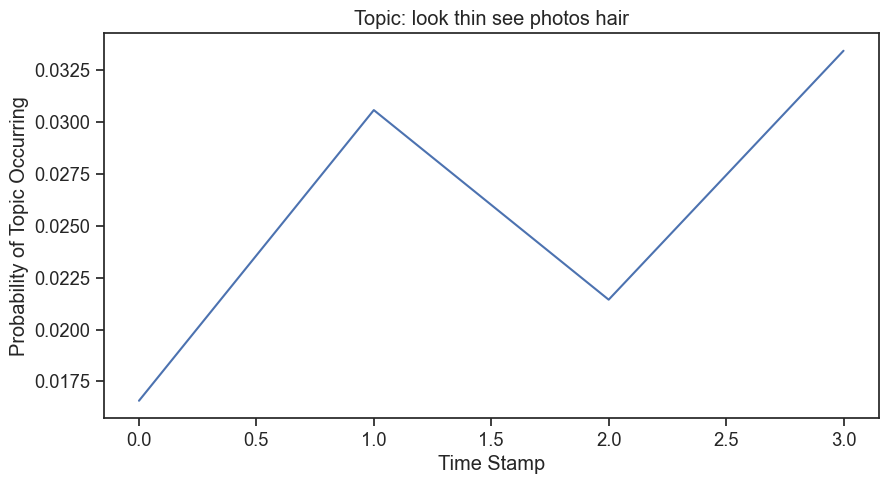

In [50]:
# Plot the distribution of the probability of each topic over time 
# Groupings contain the indices of the sentences in each post
# x-axis: created_utc
# y-axis: probability of the topic occurring in the documents (averaged)

# Choosing a topic ---- 
topic = topic_label[7]

# Get the probability of the topic occurring in each document
topic_prob = [float(x[1]) for x in ranking_topic_prob[topic]]
# Get the probability of the topic associated with each group
prob_group = []
for group in list(groupings.values()): 
    prob_group.append([topic_prob[i] for i in group])
 
# Get the average probability of the topic occurring in each post
time_series = {0: 0, 1: 0, 2: 0, 3: 0}
for item in prob_group: 
    for i in range(len(item)): 
        time_series[i] += item[i]

avg_prob = [time_series[i]/len(prob_group) for i in range(len(time_series))]

# Plot the distribution of the topic over time
plt.figure(figsize=(10,5))
plt.plot(time_series.keys(), avg_prob)
plt.xlabel("Time Stamp")
plt.ylabel("Probability of Topic Occurring")
plt.title("Topic: " + topic)
plt.show()


In [ ]:
# Get the position of each document in the ranking
ranking_pos = {}
for topic in ranking_doc: 
    for doc in ranking_doc[topic]: 
        if doc not in ranking_pos:
            ranking_pos[doc] = [(topic, ranking_doc[topic].index(doc))]
        else: 
            ranking_pos[doc].append((topic, ranking_doc[topic].index(doc)))

ranking_pos = {k: sorted(v, key=lambda x: x[1]) for k, v in ranking_pos.items()}
ranking_pos = dict(sorted(ranking_pos.items(), key=lambda item: int(item[0])))
ranking_pos

Not really interesting result because most users post about the same topic over time. Can be because the number of topics is small. However, k>5 returns topics of lower quality. 